In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.metrics import accuracy_score
class SBS():
    # 默认评价指标为 ACC
    def __init__(self, 
                 estimator, 
                 k_features, 
                 scoring=accuracy_score, 
                 test_size=0.25,
                 random_state=0):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    # 根据给定的特征子集，计算预测ACC的值
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    # 贪心迭代从原始特征中删除特征，确保每次删除评价指标最优
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=self.test_size,
                                                            random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        # 保存每次迭代后的特征组合
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        # 保存每次迭代后的评价指标
        self.scores_ = [score]
        while dim > self.k_features:
            scoreList = []
            indiceList = []
            # 从当前特征范围（个数n）中选出特征个数为（n-1）的全部子集
            # 对各个子集进行评价，最终保留评价最好的，进入下一次迭代
            for subIndices in combinations(self.indices_, len(self.indices_)-1):
                tmpScore = self._calc_score(X_train, y_train, X_test, y_test, subIndices)
                indiceList.append(subIndices)
                scoreList.append(tmpScore)
            best = np.argmax(scoreList)
            self.indices_ = indiceList[best]
            self.subsets_.append(self.indices_)
            self.scores_.append(scoreList[best])
            dim -= 1
        return self
    def transform(self, X_test):
        return X_test[:, self.indices_]

In [4]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
df_wine = pd.read_csv("F:/for learn/Python_MachineLearning/wine.data", header=None)
df_wine.columns = ['ClassLabel',
                   'Alcohol', 
                   'Malic acid', 
                   'Ash', 
                   'Alcalinity of ash', 
                   'Magnesium', 
                   'Total phenols', 
                   'Flavanoids', 
                   'Nonflavanoid phenols', 
                   'Proanthocyanins', 
                   'Color intensity', 
                   'Hue', 
                   'OD280/OD315 of diluted wines', 
                   'Proline']

X = df_wine[df_wine.columns[1:]]
y = df_wine[df_wine.columns[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(estimator=knn, k_features=1)
sbs.fit(X_train, y_train)

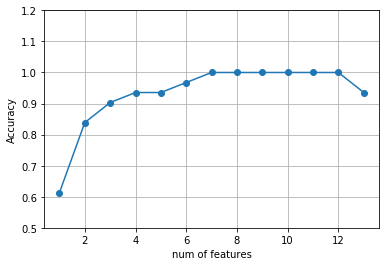

In [15]:
kFeatList = [len(indices) for indices in sbs.subsets_]
scoreList = sbs.scores_
plt.plot(kFeatList, scoreList, marker='o')
plt.ylim(0.5, 1.2)
plt.ylabel('Accuracy')
plt.xlabel('num of features')
plt.grid()
plt.show()

In [49]:
k6 = list(sbs.subsets_[np.where(np.array(kFeatList) == 6)[0][0]])
print(df_wine.columns[1:][k6])

Index(['Alcohol', 'Ash', 'Magnesium', 'Flavanoids', 'Nonflavanoid phenols',
       'Hue'],
      dtype='object')


In [51]:
knn.fit(X_train, y_train)
print("the ACC of train is:", knn.score(X_train, y_train))
print("the ACC of test is:", knn.score(X_test, y_test))

the ACC of train is: 0.983870967742
the ACC of test is: 0.944444444444


In [52]:
knn.fit(X_train[:, k6], y_train)
print("the ACC of train is:", knn.score(X_train[:, k6], y_train))
print("the ACC of test is:", knn.score(X_test[:, k6], y_test))

the ACC of train is: 0.951612903226
the ACC of test is: 0.907407407407
